In [1]:
# Make autoload
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

As an introduction to the elements of reinforcement learning we will be solving a simple problem. 

Here an agent is tasked with navigating across a field with obstacles, if the agent encounters 
an obstacle it is given a penalty and upon reaching the finished line it is rewarded. 

We will code every part of the reinforcement learning algorithm 
- The environment, i.e. the reward and transition function. 
- For an agent we will implement a policy. 
- A training loop for the agent. 

Lets start by defining the environment. In order to do so we need to consider quite a few things: 

- The state space $\mathcal{S}$
- The action space $\mathcal{A}$
- The reward function 
- The transition function, e.g. how the environment updates the state according to an action. 

For our first environment we will try to keep things simple. 

Consider a grid where there are safe 'S' places , holes 'H' and a goal 'G'. We could specify such a grid as

```
S S S S
S H S H
S S S H
U S S G
```

So this world has 16 states, our agent can be located on any of these 16 tiles. 
We decide that the available actions are moving left, down, right and up. 
So that is the state and action space. 

We also need to decide on the reward, we decide that for the agent to move to a 
safe-tile gives a reward of 0, so does moving to a hole tile but the agent dies and the episode ends, 
and finally the agent recieves a reward of 1 by getting to the goal tile which also ends the episode. 

We have now specified everything we need to define the environment in the abstract, but we are actually 
still missing some pieces in order to actually implement an algorithm. We need to decide on how we 
represent both a state and an action, whatever method we end up using to learn in this environment 
it will needs some input about both states and actions. This is analagous to descriptors for machine 
learning potentials (MLP), for MLPs we naturally need some description of the atomistic system. Similarly we need 
to to represent the state and action for our RL agent. 

For the state representation we could eg choose: 
- 2 integers describing the row and column  $[0, 3] \times [0, 3]$
- 1 integer describing both the row and the column $[0, 15]$. 

For simplicity in implementing the environment we will be using the first option, but the second option is perfect valid as well. Similarly we choose the representation of the action as a single integer between 0 and 3, like so:

$a = 0 \rightarrow $ Move left\
$a = 1 \rightarrow $ Move down\
$a = 2 \rightarrow $ Move right\
$a = 3 \rightarrow $ Move up

As for the transition between states given actions we will decide that: 
1. Transitions are deterministic.
2. Attempting 'illegal' actions returns the current state. 

The second option is basically saying that the world of environment is surronded by a wall a we will allow the agent to walk into the wall, but we will not 
allow it to go through it. We will understand why that is important later! 

In order to have a proper learning environment we need to be able specify all of these things, just to iterate that is

- A state space $\mathcal{S}$ of possible states and representations of those states $s$. 
- An action space $\mathcal{A}$ of possible actions and representations of those actions $a$. 

If we cannot do that, we do not yet have an environment suitable for reinforcement learning. 
Just being able to formulate the environment in words is not enough! We need to consider if 
appropriate representations can be created. For the current problem this is not too tricky, but 
for more complicated problems putting thought into this aspect is very important! 

In [3]:
class Environment:

    def __init__(self, max_steps=100):
        self.state = (0, 0)
        self.terminal = False
        self.truncated = False
        self.steps_taken = 0
        self.max_steps = max_steps
        self.description = np.array([c for c in 'SSSSSHSHSSSHHSSG']).reshape(4, 4)

    def step(self, action):
        """
        action: 0 (Left), 1 (Down), 2 (Right), 3 (Up)
        return: next_state, reward, terminal
        """
        
        # Convert to row and column.
        row = self.state[0]
        col = self.state[1]

        # Move
        if action == 0: # Left
            col = max(col - 1, 0) # Your code here. Hint: requires a max() function.
        elif action == 1: # Down
            row = min(row + 1, 3) # Your code here. Hint: requires a min() function.
        elif action == 2: # Right
            col = min(col + 1, 3) # Your code here. Hint: Think about the previous hints. 
        elif action == 3: # Up
            row = max(row - 1, 0) # Your code here. Hint: Think about the previous hints again. 
        
        self.state = (row, col)
        self.steps_taken += 1

        # Reward and terminal
        reward, terminal, truncated = self.reward()
        self.terminal = terminal
        self.truncated = truncated

        return self.state, reward, terminal, truncated
    
    def reward(self):
        row, col = self.state
        if self.description[row, col] == 'H':
            reward = 0
            terminal = True
        elif self.description[row, col] == 'S':
            reward = 0
            terminal = False
        elif self.description[row, col] == 'G':
            reward = 1
            terminal = True

        # Truncated: 
        truncuated = self.steps_taken > self.max_steps

        return reward, terminal, truncuated

    def reset(self):
        self.state = (0, 0)
        self.terminal = False
        self.truncated = False
        self.steps_taken = 0
        return self.state

Now that we have an environment, the second thing we need is an algorithm. We will be using Q-learning with a table. 

Here Q is the action-value function, from the Bellman equation: 

$ Q(s_t, a_t) = \mathbb{E}_{s^*} [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s^*, a^*)] $

The expectation value here is over the possible states resulting from taking action $a$ in state $s$. $\gamma$ is the discount factor, 
it weights the importance of future rewards. 
Given that we have chosen our environments has deterministic transition we can ignore that expectation value and 
reach the equation

$ Q(s_t, a_t) = [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s_{t+1}, a^*)] $

So, for a given state-action pair $(s_t, a_t)$ the Q-value is the sum of the reward and the maximum of the next state. 
Initially we dont know Q, so we will need a learning algorithm. To reach such an algorithm we write an error

$ [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} Q(s_{t+1}, a^*)] - Q(s_t, a_t)$

To minimize that, we can update the Q-value according to

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( [r_t + \gamma \mathrm{max}_{a^*} Q(s_{t+1}, a^*)] - Q(s_t, a_t) \right) = (1-\alpha) Q(s_t, a_t) +  \alpha [r_t + \gamma \mathrm{max}_{a^*} Q(s_{t+1}, a^*)]  $

Where $\alpha$ is a learning rate parameter, if $\alpha = 1$ we can see that this update rule reduces to just setting 

$ Q(s_t, a_t) \leftarrow [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s_{t+1}, a^*)] $

Which is essentially taking the Bellman equation and changing the equals sign to an arrow. 
This is the **temporal difference** target. 

Reinforcement learning often happens in 'episodes' of letting the 'agent'/algorithm explore the environment, gathering 
information and possibly training. Our agent in this case is defined by the Q-table, generally in RL we say that the agent follows 
a 'policy', in this case our policy will mostly be to choose actions according to $\mathrm{argmax}(Q(s, a))$. In order to 
have some exploration of the environment we will modify this greedy strategy, leading us to a so-called $\epsilon$-greedy policy. 
It goes as follows: 
- Draw some random number $z$
- If $z < \epsilon$ draw a random action. 
- Else choose according to $\mathrm{argmax} \ Q(s, s)$

Now we have all the elements required for our algorithm, so lets put it together. 

Our algorithm will thus be as follows: 
- Create a Q-table of just zeros of size (4, 4, 4)
- For a number of episodes repeat the following: 
1. Choose an action according to the $\epsilon$-greedy strategy. 
2. Take a step in the environment with that action, resulting in the next state, reward and a signal of whether the state is terminal or not. 
3. Update the Q-value according to the temporal difference rule from above. 
4. If the action lead to a terminal state end the episode. 


In [4]:
env = Environment()

Q_table = np.zeros((4, 4, 4), dtype=np.float64)

# Hyperparameters
epsilon = 0.1
learning_rate = 1
gamma = 0.9
num_episodes = 1000

for episode in tqdm(range(num_episodes)):

    state = env.reset()

    while not env.terminal and not env.truncated:

        # Choose action
        # If random number is less than epsilon, then select a random action
        # Else select according to the Q-values. When selecting according to Q-values,
        # if all actions have the same Q-value, then select a random action.
        # This is done to as argmax will always select the first index in the case of a tie.
        if np.random.rand() < epsilon:
            action = np.random.randint(0, 4)
        else:
            if (Q_table[state[0], state[1], :] == Q_table[state[0], state[1], 0]).all():
                action = np.random.randint(0, 4)
            else:
                action = np.argmax(Q_table[state[0], state[1]])

        # Take action by calling env.step
        next_state, reward, terminal, truncated = env.step(action)

        # Calculate Q-target
        Q_target = reward + gamma * np.max(Q_table[next_state[0], next_state[1]]) - Q_table[state[0], state[1], action]
        # if not terminal:
        #     Q_target = reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action]
        # else:
        #     Q_target = reward - Q_table[state, action]

        # Update Q-table
        Q_table[state[0], state[1], action] += learning_rate * Q_target

        state = next_state

100%|██████████| 1000/1000 [00:00<00:00, 4221.38it/s]


In order to figure out whether things are working the folowing cell will plot the Q-values learned by your agent. 

The figure shows the learned Q-values for each action of each state, if any of the Q-values differ from zero. 
To understand from the visualization whether your implementation is working or not, you might have to think about what 
the true Q-values for this problem are: 

- What should the Q-value be for state-action pairs that lead to the goal be? 
- What should Q-values for state-actions pairs that lead to hole tiles be? 
- How should the Q-values depend on the discount factor $\gamma$? 
- What should the Q-values for illegal actions be? 

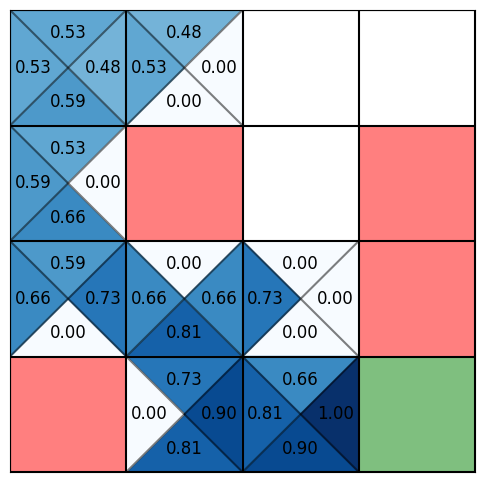

In [5]:
from rlweek.utils.plot_qvalues import plot_qvalues

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

q_table_reshaped = Q_table.reshape(16, 4)
plot_qvalues(ax, q_table_reshaped, desc=env.description)

When your convinced your algorithm works try playing around with the hyperparameters. 

- What happens if $\epsilon$ is very small? 
- What happens if $\gamma$ is small? 
- Can you set the parameters such that multiple valid paths to the goal are learned? Or that the Q-values match the correct ones? 

##### Exercise: 

As a final task for this tabular Q-learning algorithm try to alter your code such that it works with an inital Q-table that is not just zeros. This will be relevant for an upcoming topic, Q-learning with neural networks where we cannot easily ensure that intiial Q-values are all zero. At first, try just changing the initial table to a random one - what happens then? Consider whether the update rule we are using makes sense for state-action pairs that lead to terminal states, what happens in that case? 

### Q-network rather than Q-table. 

Having a table in 2023 is very embarassing, so lets replace that table with a network. 

What do we want from that network? We want it to be able to predict action-values Q given a state and an action, but that is not completely specific. 

We have multiple options: 
- The network could take both a state $s$ and an action $a$ and predict a single Q-value. 
- The network could take only the state and predict all Q-values for that particular state. 

We will opt for the second option, but the first one should work as well. 

So for the first option we want a network that 
- Takes a state as input, e.g. it takes 2 numbers. 
- Outputs 4 numbers corresponding to the 4 actions available for each state. 

In [6]:
import torch 
#import pytorch_lightning as pl

In [7]:
from typing import Any

class Q_network(torch.nn.Module):

    def __init__(self, learning_rate=1e-3, hidden_dim=16, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = torch.nn.Linear(2, hidden_dim) # You can play around with these 
        self.layer_2 = torch.nn.Linear(hidden_dim, hidden_dim) # numbers to see how small of a 
        self.layer_3 = torch.nn.Linear(hidden_dim, 4) # network you can make work. 

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):

        x = self.layer_1(x)
        x = torch.relu(x)

        x = self.layer_2(x)
        x = torch.relu(x)

        x = self.layer_3(x)

        return x

    def train(self, states, actions, targets):
        # Forward pass
        outputs = self.forward(states)
        selected_outputs = outputs[range(outputs.shape[0]), actions]

        # Compute loss
        loss = torch.nn.functional.mse_loss(selected_outputs, targets)

        # Backward pass
        #self.backward(loss, self.optimizer, None)

        # Update weights
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.detach().numpy()

def state_to_tensor(state):
    return torch.tensor([[state[0], state[1]]], dtype=torch.float32)


# Check that our network works as expected. 
model = Q_network()
s = torch.tensor([0, 0], dtype=torch.float32)
assert model.forward(s).shape == (4,)

Before we try learning directly with the Q-network we can try something simpler, we can try just learning the Q-table we learned before. 

In [8]:
def get_batch(Q_table, size=16):

    states = np.random.randint(0, 4, size=(size, 2))
    actions = np.random.randint(0, 4, size=size)
    targets = Q_table[states[:, 0], states[:, 1], actions]

    # Convert to tensors: 
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)
    targets = torch.tensor(targets, dtype=torch.float32)    

    return states, actions, targets


# Train the network
model = Q_network(learning_rate=1e-3)
loss = []
for _ in tqdm(range(5000)):
    states, actions, rewards = get_batch(Q_table, size=64)
    l = model.train(states, actions, rewards)
    loss.append(l)

# Make a table of its predictions: 
Q_table_nn = np.zeros((4, 4, 4), dtype=np.float64)

for row in range(4):
    for col in range(4):
        state = (row, col)
        state_tensor = state_to_tensor(state)
        Q_table_nn[row, col] = model.forward(state_tensor).detach().numpy()

100%|██████████| 5000/5000 [00:05<00:00, 879.23it/s]


We can plot the Q-values for both the table and the network. 

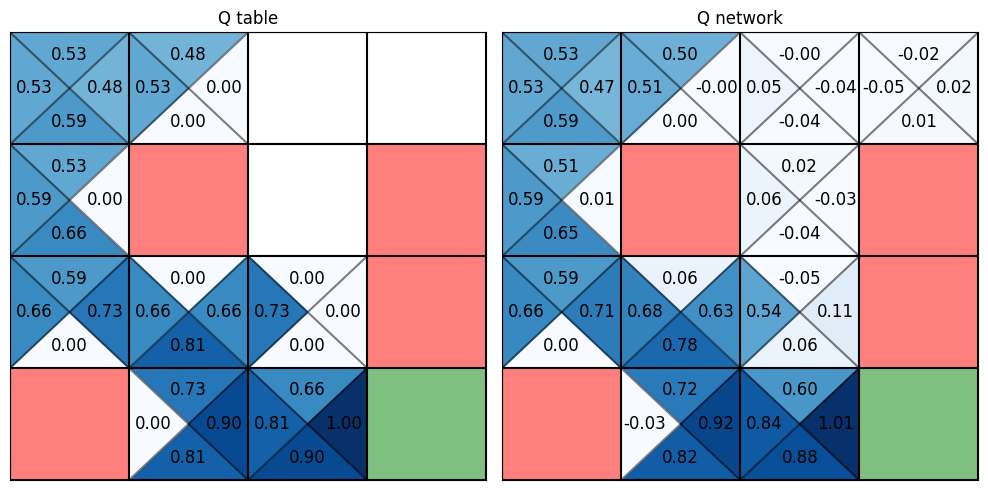

In [9]:
# Make a table of its predictions: 
Q_table_nn = np.zeros((4, 4, 4), dtype=np.float64)

for row in range(4):
    for col in range(4):
        state = (row, col)
        state_tensor = state_to_tensor(state)
        Q_table_nn[row, col] = model.forward(state_tensor).detach().numpy()
        
sz = 5
fig, ax = plt.subplots(1, 2, figsize=(2*sz, 1*sz))

plot_qvalues(ax[0], Q_table.reshape(16, 4), desc=env.description)
plot_qvalues(ax[1], Q_table_nn.reshape(16, 4), desc=env.description)

ax[0].set_title('Q table')
ax[1].set_title('Q network')
plt.tight_layout()


### Learning with a Q-network. 

When running an episode for the training of the Q-table we updated the table every step, 
whereas when we trained the network towards the the table we used batches of data. 

Using batches is both more efficient in terms of computational speed, but also provides 
more reliable gradients - so we would like to use batches of data for our Q-network learning 
algorithm. To do so we will create an experience replay memory, that we can draw batches from and we 
will not be training every step. 

Our Q-learning algorithm with a table was an *on-policy* algorithm, we were updating the 
table with rewards and Q-values found with the current policy, as we were simply just
updating according to the most recent step. With the experience replay, we get an *off-policy* algorithm, 
the training data does not necesarily come from the current policy. 

The temporal difference target that we used before, depends on the predictions of the network for new state: 

$TD = [r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q(s_{t+1}, a^*)]$

That can create some instability, so a trick/innovation to stabilize the training is to use 
two networks. 
- The main network that we are training
- A target network where the weights are copied from the main network every so often. 

This avoids training the main network towards a constantly moving target. 

So an outline of the algorithm we want is as follows: 

0. Create two networks: main and target. 
1. Run a number of steps to gather data that we store in a experience replay. 
2. Train main network on data from the experience replay. 
3. Occassionally copy the weights from the main network to the target network. 

Or in pseudo-code

<img src="images/deep_q_learning.png" />

From [Mnih et.al, Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236/)

The notation is slightly different because they convet states $s$ to $\phi$ because they deal with frames of a game where multiple frames are stacked together 
to give a final representation of a state - this allows representation of moving objects. But for us this is not important. 

In [18]:
class ExperienceReplay: 

    def __init__(self, size=100, batch_size=16):
        self.batch_size = batch_size
        self.size = size
        self.clear()

    def add(self, state, action, reward, new_state, terminal):
        self.states[self.index] = torch.tensor(np.array(state))
        self.actions[self.index] = torch.tensor(action)
        self.rewards[self.index] = torch.tensor(reward)
        self.new_states[self.index] = torch.tensor(np.array(new_state))
        self.terminal[self.index] = torch.tensor(terminal)

        self.index += 1
        if self.index == self.size:
            self.index = 0

        if self.current_size < self.size:
            self.current_size += 1

    def get_batch(self):
        indices = np.random.randint(0, self.current_size, size=self.batch_size)
        return self.states[indices], self.actions[indices], self.rewards[indices], self.new_states[indices], self.terminal[indices]
    
    def clear(self):
        self.states = torch.tensor(np.zeros((self.size, 2)), dtype=torch.float32)
        self.new_states = torch.tensor(np.zeros((self.size, 2)), dtype=torch.float32)
        self.rewards = torch.tensor(np.zeros(self.size), dtype=torch.float32)
        self.actions = torch.tensor(np.zeros(self.size), dtype=torch.int32)
        self.terminal = torch.tensor(np.zeros(self.size), dtype=torch.bool)
        self.current_size = 0
        self.index = 0

from copy import deepcopy
def copy_weights(model_from, model_to):
    model_to.load_state_dict(deepcopy(model_from.state_dict()))

# To ensure your replay is working this line runs some tests. 
from rlweek.utils.test_qlearning import test_replay
test_replay(ExperienceReplay)

In [11]:
model_1 = Q_network(learning_rate=1e-3)
model_2 = Q_network(learning_rate=1e-3)

# Copy weights from model_1 to model_2
copy_weights(model_1, model_2)

# Check that the weights are the same
for p1, p2 in zip(model_1.parameters(), model_2.parameters()):
    assert (p1.detach().numpy() == p2.detach().numpy()).all()

We need a `train` function that takes the replay buffer, both networks and the $\gamma$-value and trains the `main`-network. 

In [12]:
def train(replay, main, target, gamma):
    
    # Get a batch of data from the replay buffer
    states, actions, rewards, new_states, terminal = replay.get_batch()
    batch_size = len(states)

    # Calculate the Q-values for the current state
    Q = main(states)

    # Calculate the Q-values for the next state
    Q_next = target(new_states).detach()
    Q_next_max = torch.max(Q_next, dim=1).values

    # Calculate the TD-target - Remember to use the terminal states such that 
    # the target for terminal states is just the reward. 
    # torch.logical_not is useful here. 
    td_target = rewards + torch.logical_not(terminal) * gamma * Q_next_max

    # Calculate the loss
    Q = Q[torch.arange(batch_size), actions]
    loss = torch.nn.functional.mse_loss(Q, td_target)

    # Backpropagate the loss
    loss.backward()
    main.optimizer.step()
    main.optimizer.zero_grad()

    return loss.detach().numpy()

from rlweek.utils.test_qlearning import test_train
test_train(train, ExperienceReplay, Q_network)

In [15]:
env = Environment()

# Create networks & copy weights from main to target
main_network = Q_network(learning_rate=1e-3)
target_network = Q_network(learning_rate=1e-3)
copy_weights(main_network, target_network)

# Create replay buffer
replay = ExperienceReplay(size=1000, batch_size=64)

# Hyperparameters
gamma = 0.90
num_episodes = 1000
train_interval = 1
copy_interval = 100
epsilon = lambda i: 0.1

step_count = 0
for episode in tqdm(range(num_episodes)):

    state = env.reset()

    while not env.terminal and not env.truncated:

        # Choose action
        # If random number is less than epsilon, then select a random action
        # Else select according to the Q-values. When selecting according to Q-values,
        # if all actions have the same Q-value, then select a random action.
        # This is done to as argmax will always select the first index in the case of a tie.
        if np.random.rand() < epsilon(episode):
            action = np.random.randint(0, 4)
        else:
            state_tensor = state_to_tensor(state)
            Q = main_network(state_tensor).detach().numpy()
            action = np.argmax(Q)

        # Take action by calling env.step
        next_state, reward, terminal, truncated = env.step(action)
        step_count += 1

        # Add to replay buffer
        replay.add(state, action, reward, next_state, terminal)

        # Train the network.
        if step_count % train_interval == 0 and step_count > 200:
            train(replay, main_network, target_network, gamma=gamma)

        # Update the target network. 
        if step_count % copy_interval == 0:
            copy_weights(main_network, target_network)        

        # Update state
        state = next_state

100%|██████████| 1000/1000 [01:14<00:00, 13.40it/s]


We plot the results

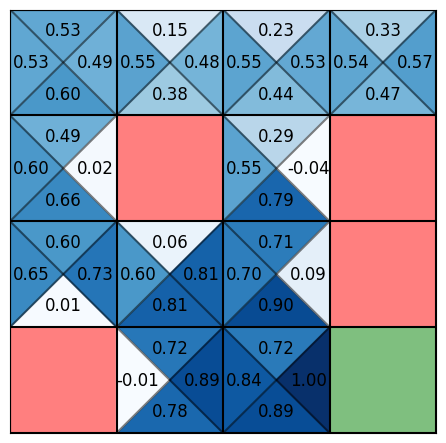

In [19]:
# Make a table of its predictions: 
Q_table_nn = np.zeros((4, 4, 4), dtype=np.float64)

for row in range(4):
    for col in range(4):
        state = (row, col)
        state_tensor = state_to_tensor(state)
        Q_table_nn[row, col] = main_network.forward(state_tensor).detach().numpy()
        
sz = 5.5
fig, ax = plt.subplots(1, 1, figsize=(1*sz, 1*sz))
plot_qvalues(ax, Q_table_nn.reshape(16, 4), desc=env.description)


The algorithm is rather sensitive to many of the parameters. So if things are not working but you're convinced the code is correct, try varying the

- The epsilon strategy. 
- Number of episodes. 
- How often the target network is updated. 

Reinforcement learning is a field filled with tricks, it can be difficult to distinguish between when something is a trick and when something is a proper method. 
For example, the replay buffer and use of two networks is kind of a trick - but are also pretty much neccesary to make things work. 
So we need to be able to utilize such tricks, so as an exercise we will implemenet a final trick for our Q-learning algorithm. 

Remember the temporal difference target: 

$Q^{main}(s_t, a_t) \leftarrow r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q^{target}(s_{t+1}, a^*)$

The Q-values are noisy, we don't know them exactly (unsurprisingly, given this is an equation for training). Especially the $\mathrm{max}$ operation is vulnerable to noise and bias, which might make us train towards unreaslisticly high Q-values. A trick to avoid this is so called Double Q-learning, in words what we want to do is: 

1. Find the action of the next state using our main network $a^m = \mathrm{argmax} Q^{main}(s_{t+1}, a^*)$. 
2. Use that action to calculate the Q-value from the target network. 

Putting that together we get

$Q^{main}(s_t, a_t) \leftarrow r(s_t, a_t) + \gamma Q^{target}(s_{t+1}, \mathrm{argmax} \ Q^{main}(s_{t+1}, a^*))$

Change the `train` function to implement this. 
